# Using Deep Learning Algorithms

The aim of this correction is to guide you through the process of using deep learning algorithms. The apporach in itself is different from the one used for machine learning, which can be summarized as follows:
- There is no simple or unique truth.

- **Reflection** on models and **experimentation** is as important as the score obtained.

- The **limits** of classical models are (far) easier to reach.

- Deep Learning requires **more effort** for sometimes a small gain (but can explode with the right conditions).

## Toolbox & terms

In deep learning, several concepts and tools are essential for optimizing model training and performance. Here are the key elements to understand:

### Data augmentation

Data augmentation is a technique that artificially increases the size of the training dataset by applying various transformations to existing data. For spectral data, this can include:

- Adding controlled Gaussian noise
- Applying minor vertical or horizontal shifts
- Creating linear combinations of similar spectra
- Using smoothing or filtering techniques

This approach helps improve model robustness and reduce overfitting.

You can find the implementation of it for teh notebook in the file `src\data_augmenter.py`

### Data normalization & standardization

Data normalization and standardization are preprocessing steps that can be crucial for deep learning, but their use should be carefully considered:

- **Advantages**: Speeds up convergence, stabilizes learning, enables better generalization
- **Disadvantages**: May mask natural patterns, adds computational complexity

While deep learning can theoretically learn necessary normalizations, in practice, appropriate preprocessing often facilitates learning and reduces convergence time.




## 🧅 Layers

In a Deep Neural Network (DNN), a **layer** is a building block that transforms input data into output features. Each layer learns to extract or transform patterns from data, contributing to the final prediction.

There are different types of layers, each designed for specific purposes. Here's a breakdown of the most common ones:


### 🔗 Dense Layer (Fully Connected)

A **dense layer** (also called a **fully connected layer**) connects **every input neuron to every output neuron**.

It performs a linear transformation followed by a non-linear activation:

```math
\text{output} = \sigma(Wx + b)
```

Where:
- `x` is the input vector
- `W` is the weight matrix
- `b` is the bias vector
- `σ` is an activation function (e.g., ReLU, sigmoid)

#### 💡 Dense Layer vs Perceptron

A **single perceptron** is essentially a dense layer with just one output neuron.  
Dense layers **generalize** perceptrons to multiple outputs and can be stacked to form deeper networks.


### 🔍 Convolutional Layer

A **convolutional layer** is designed to process data with a spatial or sequential structure, like images or time series.

Instead of connecting every input to every output (as in dense layers), it uses small **learnable kernels** that slide over the input and detect local patterns.

- Each kernel produces one feature map
- Convolutional layers are efficient and preserve spatial relationships
- Ideal for vision, audio, and signal processing tasks


### ⬇ Pooling Layer

A **pooling layer** reduces the spatial size of feature maps and helps make representations more invariant to small shifts or distortions.

Common types:
- **Max Pooling**: takes the maximum value in each window
- **Average Pooling**: takes the average value

Pooling helps:
- Reduce the number of parameters
- Control overfitting
- Improve translation invariance


### 🎲 Dropout Layer

A **dropout layer** randomly deactivates a fraction of neurons during training (e.g., 20%–50%) to prevent overfitting.

- At each training step, some neurons are "dropped" (set to zero)
- At inference time, all neurons are active, but their outputs are scaled accordingly

Dropout acts as a form of **regularization**, forcing the network to rely on distributed representations rather than memorizing specific features.


### ✅ Summary

| Layer Type       | Purpose                                    | Connectivity        |
|------------------|--------------------------------------------|---------------------|
| Dense            | General transformation, classification     | Fully connected     |
| Convolutional    | Pattern detection in spatial data          | Locally connected   |
| Pooling          | Downsampling, invariance to shifts         | Fixed, non-learned  |
| Dropout          | Regularization, prevents overfitting       | Randomly zeroed out |

Layers are stacked to form deep architectures where each layer transforms the data closer to a meaningful representation or decision.

---

### 🔍 More about the Convolution Kernel

At the heart of a Convolutional Neural Network (CNN) is the **convolution kernel**, also known as a **filter**.

- A **kernel** is a small learnable array of weights.
- In 1D convolution, it is a 1D array (e.g., of size 3, 5, or 7).
- The kernel **slides** over the input sequence, computing a weighted sum at each position.
- This operation extracts local patterns or features (like edges, shapes, or motifs).

Each kernel produces one output channel (also called a **feature map**). In practice, CNNs learn **multiple kernels** to detect different features in the data.



### 🔁 `stride`

- The **stride** defines how far the kernel moves at each step.
- A `stride` of 1 means the kernel moves one position at a time (maximum overlap).
- A higher `stride` (e.g., 2 or 3) skips positions, which reduces the output size.

**Example:**
- Input length = 10, kernel size = 3, stride = 2 → kernel moves at positions 0, 2, 4, etc.


### ⬛ `padding`

- **Padding** adds extra elements (usually zeros) to the input on both sides.
- It allows the kernel to cover border elements and helps preserve the input size.
- Common types:
  - `"valid"`: no padding (output is smaller)
  - `"same"`: padding chosen to keep output size equal to input (if stride = 1)


### 📏 Output Size Formula (1D convolution, no dilation)

Given:
- `L_in`: input length
- `padding`: number of padding elements added to each side
- `kernel_size`: size of the convolution kernel
- `stride`: step size of the kernel

The output length is:

```math
L_{out} = \left\lfloor \frac{L_{in} + 2 \cdot \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
```
This formula tells you how many times the kernel fits as it moves across the input. This formula accounts for the kernel’s movement and boundary handling

### ✅ Key Takeaways
- The kernel is the pattern detector.

- Larger stride → smaller output

- More padding → larger output (up to original size)





## Data and Deep Learning

To better replace the context, we will plot again a representation of our dataset, which are hyperspectral unidimensional data. We will perform *some* algorithms of deep learning, exploring the $infinite* possibility that is yields.

Our task is still to predict a value, for the regression task, or a label, for the classification task.


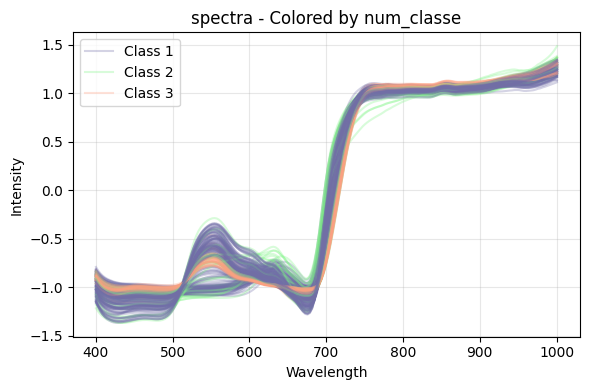

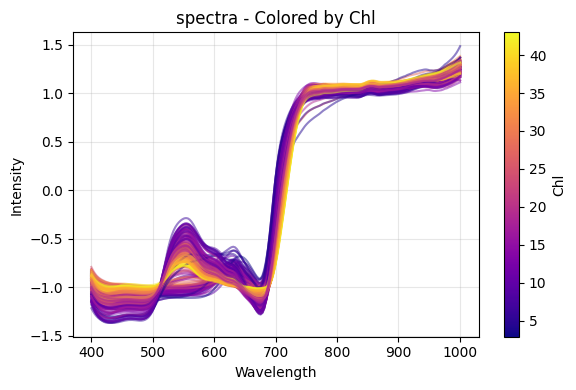

In [2]:
import sys
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, r2_score,classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
import numpy as np

# Get current notebook path
notebook_path = Path.cwd()
# Go up one level to reach project root
project_root = notebook_path.parent
sys.path.insert(0, str(project_root))

from scripts.dataLoading import data_3cl, spectral_cols, mat_snv_sg_3cl
from src.dataset import Dataset, InputType, GroupConfig

full_data = mat_snv_sg_3cl.merge(data_3cl[["num_classe", "Chl"]], left_index=True, right_index=True)
# Create group configurations
groups = [
    GroupConfig(
        features_label=spectral_cols.tolist(),
        type=InputType.FUNCTIONAL,
        group_name="spectra"
    )
]

# Create dataset with both spectral and metadata inputs
dataset_3cl = Dataset(
    data=full_data,
    output_labels=["num_classe", "Chl"],
    input_labels=spectral_cols.tolist(),
    input_groups=groups
)

dataset_3cl.show()





The focus will be on understanding the plots and results, and critical thinking about the pros and cons of each algroithms, and deep learning in genaral.

We will focus on two tasks:
- A regression task predicting the `Chl` (Chlorophyll) value
- A classification task predicting the `num_classe` category

For the classification task, we will use the raw class labels rather than one-hot encoding. While one-hot encoding is possible, research suggests it can be detrimental for neural networks, particularly regarding gradient properties during training.

As deep learning is a highly empirical field, we will explore different neural network architectures rather than making broad generalizations. Specifically, we will implement and compare:

1. A simple perceptron model
2. A deep convolutional neural network (CNN)

For both architectures, we will evaluate performance with and without data augmentation during training to assess its impact.

As it is by nature not a "correction", but more as a methodology, it is encouraged to run all the available script by tweeting their hyperparameters, and/or modyfying the architecture of the network.

### Algorithms

We will review various models, varying from the percpetron to a *quite complex* Convolutional Neural Network (particularly adapted for our dataset)

- [Perceptron notebook](algo_dl/perceptron.ipynb)

- [CNN notebook](algo_dl/cnn.ipynb)



### Conclusion

While we have seen that deep learning algorithms can provide better results that machine learning algorithms, it is not always (often ?) the solution required, except on *very* large dimensional problems, or for a solution that can be only *marginaly* better.

Pros:
 - Can theorically approximate "all" the models you could think of, non linear ones included (particularly)
 - Less sensible to pretreatments, as it can learn the pretreatment by itself

Cons: 
 - **Very** time consuming
 - Need **a lot** of inspecting of varying architecture and hyperparmeters, which multiply exponentially the time needed to find a good model. Only data speaks, subjectivity and opinion should stay at the doorstep, or at least by challenged by observations
 - Due to its nature, very prone to **overfitting**
 - More **complex** means more time to properly tune it